## Computation Time

This jupyter notebook creates plots to study the impact of EVs on computational time

### 0. Analysis IDs to compare

In [1]:
# Define the analysis_ids that we want to compare
analysis_ids = (162, 163)

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
# Plotly for plotting 
#!pip install plotly

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

### 2. Environment Variables

In [6]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [8]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [9]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [10]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [14]:
sql_count_stats = """select lai.action_tstamp_tx                                                   as start_time,
       lau.aid,
       lau.action_tstamp_tx                                                   as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
           ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
             DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
            DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx))     as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
where lai.action = 'I'
;"""
data = '|'.join(map(str,analysis_ids))
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=())
count_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,time_taken_tripgen,time_taken_eviabm
0,2020-08-16 07:12:12.244418+00:00,57,2020-08-16 07:18:57.795066+00:00,2020-08-22 21:37:57.954841+00:00,# EV: 1201,6.0,9499.0
1,2020-08-17 22:29:04.973577+00:00,60,2020-08-17 22:36:30.877933+00:00,2020-08-23 07:05:51.762363+00:00,# EV: 1146,7.0,7709.0
2,2020-08-18 05:57:50.040039+00:00,67,2020-08-18 06:06:09.875607+00:00,2020-08-24 04:06:52.607810+00:00,# EV: 1139,8.0,8520.0
3,2020-08-20 19:58:34.950347+00:00,70,2020-08-20 20:06:50.958464+00:00,2020-08-26 16:31:10.735190+00:00,# EV: 1302,8.0,8424.0
4,2020-08-25 18:06:52.133531+00:00,71,2020-08-25 18:17:33.929126+00:00,2020-08-27 05:23:16.715010+00:00,# EV: 1302,10.0,2105.0
...,...,...,...,...,...,...,...
294,2021-03-03 17:53:18.687592+00:00,450,2021-03-03 19:23:37.960528+00:00,2021-03-03 23:14:36.072073+00:00,# EV: 915,90.0,230.0
295,2021-03-03 17:53:54.275461+00:00,452,2021-03-03 19:24:21.744338+00:00,2021-03-03 23:27:49.357542+00:00,# EV: 900,90.0,243.0
296,2021-03-03 17:54:20.846145+00:00,454,2021-03-03 19:25:59.116426+00:00,2021-03-03 23:06:29.150673+00:00,# EV: 886,91.0,220.0
297,2021-03-04 01:34:18.380897+00:00,459,2021-03-04 02:42:46.999587+00:00,2021-03-04 06:08:04.247369+00:00,# EV: 890,68.0,205.0


### 5. Plotting

#### 5.1 Time taken trigen

In [15]:
count_stats['ev_count']

0      # EV: 1201
1      # EV: 1146
2      # EV: 1139
3      # EV: 1302
4      # EV: 1302
          ...    
294     # EV: 915
295     # EV: 900
296     # EV: 886
297     # EV: 890
298     # EV: 871
Name: ev_count, Length: 299, dtype: object

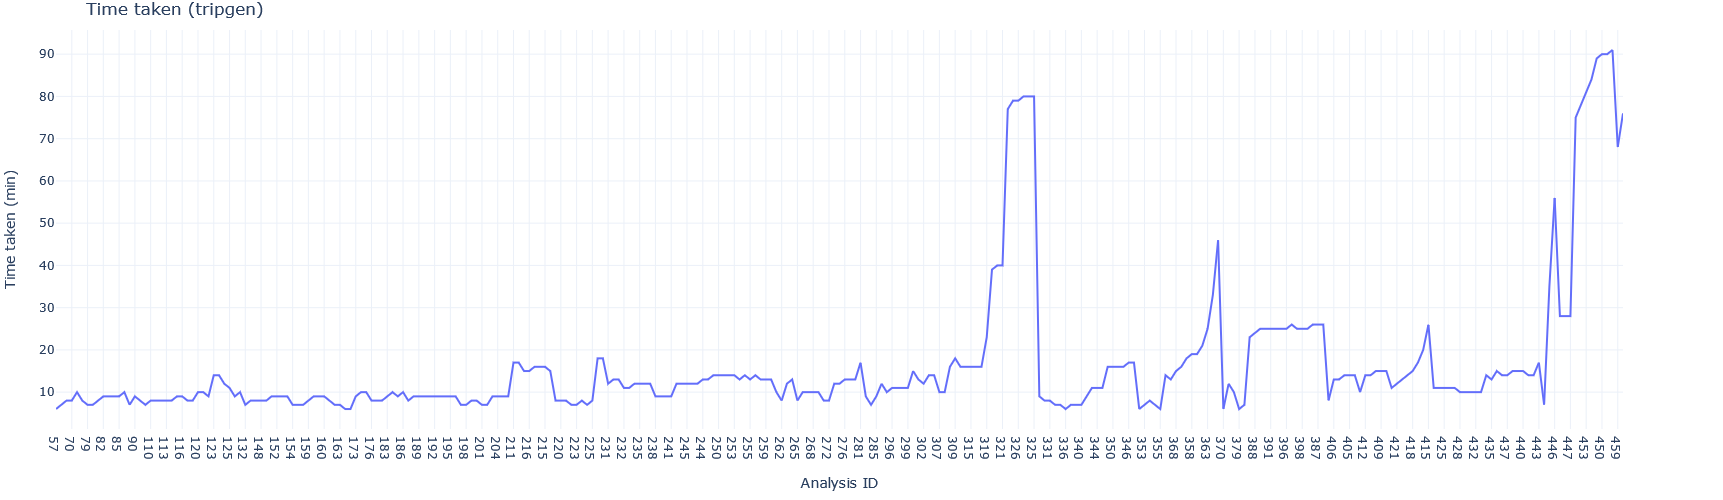

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=count_stats['aid'], y=count_stats['time_taken_tripgen'],
                         
                         text=count_stats['ev_count'],
                         textposition="top center"))
fig.update_xaxes(type='category')
fig.update_layout(title="Time taken (tripgen)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Analysis ID", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1500, 
                  height=500, 
                  margin=dict(l=20, r=100, t=30, b=20),
                 template='plotly_white')
fig.show()

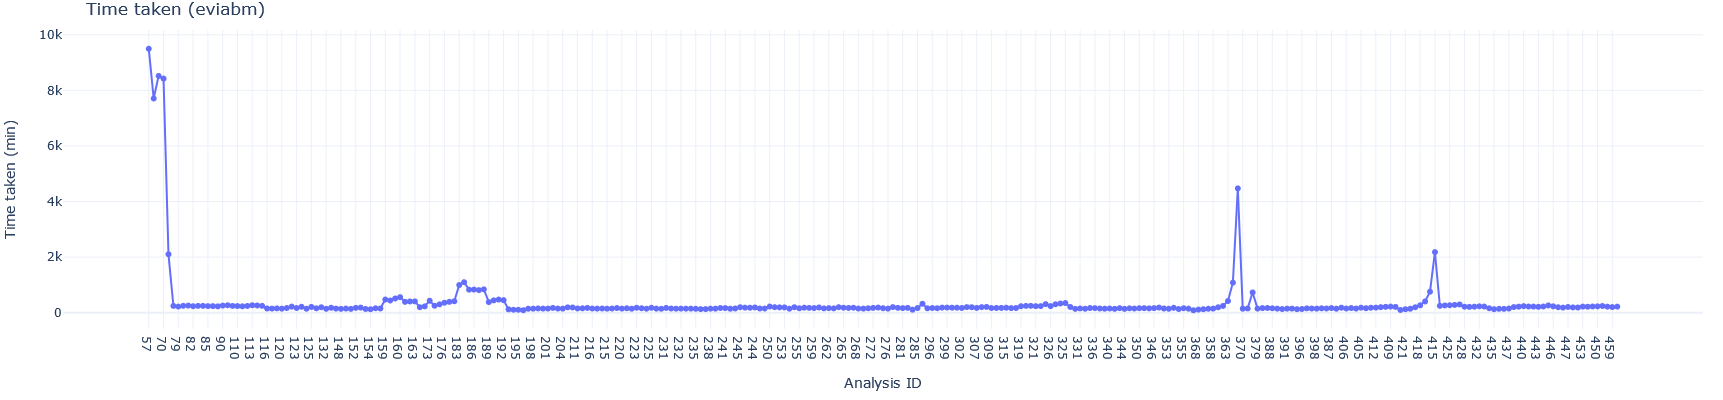

In [20]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=count_stats['aid'], y=count_stats['time_taken_eviabm'],
                    mode='lines+markers+text',
                    name='lines+markers'))
fig.update_xaxes(type='category')
fig.update_layout(title="Time taken (eviabm)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Analysis ID", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20),
                  template='plotly_white')
fig.show()